<a href="https://colab.research.google.com/github/flecue/CLIP-Usage/blob/main/CLIP_Face_descrimination.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Credits: https://colab.research.google.com/drive/1ZSDOa6W5NxNdIwT79zFCEE4UwQ3PZjoU?usp=sharing

# Using CLIP to classify photos of people

This notebook presents classification of famous people from Russia (mostly politicians) based on CLIP zero-short transfer learning capabilities.



# Download and Install CLIP Dependencies

> Indented block

In [1]:
# installing some dependencies, CLIP was released in PyTorch
import subprocess

CUDA_version = [s for s in subprocess.check_output(["nvcc", "--version"]).decode("UTF-8").split(", ") if s.startswith("release")][0].split(" ")[-1]
print("CUDA version:", CUDA_version)

if CUDA_version == "10.0":
    torch_version_suffix = "+cu100"
elif CUDA_version == "10.1":
    torch_version_suffix = "+cu101"
elif CUDA_version == "10.2":
    torch_version_suffix = ""
else:
    torch_version_suffix = "+cu110"

!pip install torch==1.7.1{torch_version_suffix} torchvision==0.8.2{torch_version_suffix} -f https://download.pytorch.org/whl/torch_stable.html ftfy regex

import numpy as np
import torch

print("Torch version:", torch.__version__)

CUDA version: 11.0
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |███████████████████████         | 834.1MB 1.3MB/s eta 0:04:07tcmalloc: large alloc 1147494400 bytes == 0x5555b92fe000 @  0x7f7771040615 0x555580b2d06c 0x555580c0ceba 0x555580b2fe8d 0x555580c2199d 0x555580ba3fe9 0x555580b9eb0e 0x555580b3177a 0x555580ba3e50 0x555580b9eb0e 0x555580b3177a 0x555580ba086a 0x555580c227c6 0x555580b9fee2 0x555580c227c6 0x555580b9fee2 0x555580c227c6 0x555580b9fee2 0x555580c227c6 0x555580ca4431 0x555580c05049 0x555580b6fc84 0x555580b308e9 0x555580ba4ade 0x555580b3169a 0x555580b9fa45 0x555580b9ee0d 0x555580b3177a 0x555580b9fa45 0x555580b3169a 0x555580b9fa45
     |█████████████████████████████▏  | 1055.7MB 1.3MB/s eta 0:01:20tcmalloc: large alloc 1434370048 bytes == 0x5555fd954000 @  0x7f7771040615 0x555580b2d06c 0x555580c0ceba 0x555580b2fe8d 0x555580c2199d 0x555580ba3fe9 0x555580b9eb0e 0x555580b3177a 0x555580ba3e50 0x555580b9eb0e 0x555580b3177a 0x555580ba086a 0x555580c227

In [2]:
!pip install gdown

In [3]:
# clone the CLIP repository
!git clone https://github.com/openai/CLIP.git

import sys
from pathlib import Path

clip_dir = Path(".").absolute() / "CLIP"
sys.path.append(str(clip_dir))
print(f"CLIP dir is: {clip_dir}")

import clip

Cloning into 'CLIP'...
remote: Enumerating objects: 74, done.
remote: Total 74 (delta 0), reused 0 (delta 0), pack-reused 74
Unpacking objects: 100% (74/74), done.
CLIP dir is: /content/CLIP


In [4]:
# Load pre-trained model
import os

device = "cuda" if torch.cuda.is_available() else "cpu"
model, transform = clip.load("ViT-B/32", device=device)
print(f"Model dir: {os.path.expanduser('~/.cache/clip')}")

100%|███████████████████████████████████████| 354M/354M [00:05<00:00, 60.4MiB/s]


Model dir: /root/.cache/clip


# Obtain the data

We will use a couple of photos, which I manually downloaded from the internet. Photos show three different persons (2 female, 1 male) and there are 4 to 6 images of each person.
Photos are stored in folders named `Donald`, `Elena` and `Svetlana`. However, we will try CLIP with various names to see the effect.

In [5]:
!gdown https://drive.google.com/uc?id=1sGcW7XsiwvnuRMbeIeQJZCeM9D6R6m_O
!unzip clip_people.zip; rm clip_people.zip

Downloading...
From: https://drive.google.com/uc?id=1sGcW7XsiwvnuRMbeIeQJZCeM9D6R6m_O
To: /content/clip_people.zip
2.87MB [00:00, 91.4MB/s]
Archive:  clip_people.zip
   creating: clip_people/
   creating: clip_people/Donald/
 extracting: clip_people/Donald/2.jpg  
 extracting: clip_people/Donald/3.jpg  
 extracting: clip_people/Donald/4.jpg  
 extracting: clip_people/Donald/93cff841b630c47dd55c.jpg  
 extracting: clip_people/Donald/ezgif-3-8bd4c099df50.jpg  
 extracting: clip_people/Donald/ezgif-3-a3137b1ec3ba.jpg  
   creating: clip_people/Elena/
 extracting: clip_people/Elena/1550606477_701561d4aefa6c271b85916f73fbf073.jpg  
 extracting: clip_people/Elena/238125337.jpg  
 extracting: clip_people/Elena/528px-Valentina_Matviyenko_(7)_(cropped).jpg  
 extracting: clip_people/Elena/D3nQOKWWwAAlkXL.jpg  
 extracting: clip_people/Elena/valentina-matvijenko-65838704.jpg  
 extracting: clip_people/Elena/Valentina_Matviyenko.jpg  
   creating: clip_people/Svetlana/
 extracting: clip_people/Sv

# Class labels

We need class definitions for the classification task. Class definitions are provided as text that describe images. For example, `this is an image showing a cat`. Here, `cat` is our class of interest.

CLIP may be sensitive to use of words in text description. You may need to do your own experiments. Below I will show the effect of this.

In [6]:
import os
# images we want to test are stored in folders with class names
class_names = sorted(os.listdir('./clip_people/'))
class_to_idx = {class_names[i]: i for i in range(len(class_names))}
class_names

['Donald', 'Elena', 'Svetlana']

In [7]:
class_captions = [f"An image depicting a {x}" for x in class_names]
class_captions

['An image depicting a Donald',
 'An image depicting a Elena',
 'An image depicting a Svetlana']

Now we tokenize the text and calculate embeddings from tokens

In [9]:
text_input = clip.tokenize(class_captions).to(device)
print(f"Tokens shape: {text_input.shape}")

with torch.no_grad():
    text_features = model.encode_text(text_input).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)
print(f"Text features shape: {text_features.shape}")

Tokens shape: torch.Size([3, 77])
Text features shape: torch.Size([3, 512])


# Prepare images

We will consume images with the help of `ImageFolder` dataset from `PyTorch`.

In [10]:
# In order to display the image we will need to de-nonrmalize them
image_mean = torch.tensor([0.48145466, 0.4578275, 0.40821073]).to('cpu')
image_std = torch.tensor([0.26862954, 0.26130258, 0.27577711]).to('cpu')

def denormalize_image(image: torch.Tensor) -> torch.Tensor:
    image *= image_std[:, None, None]    
    image += image_mean[:, None, None]
    return image

In [11]:
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

In [12]:
dataset = ImageFolder(root="./clip_people", transform=transform)
data_batches = DataLoader(dataset, batch_size=len(dataset), shuffle=False)

In [13]:
plt.figure(figsize=(10, 10))

# Show all images from the dataset since our dataset is small
for idx, (image, label_idx) in enumerate(dataset):
    cur_class = class_names[label_idx]    
    
    plt.subplot(4, 4, idx+1)
    plt.imshow(denormalize_image(image).permute(1, 2, 0))
    plt.title(f"{cur_class}")
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()

# Perform classification

Let's perform the classification with our out of the box labels.

In [14]:
# read out all images and true labels
image_input, y_true = next(iter(data_batches))
image_input = image_input.to(device)

with torch.no_grad():
    image_features = model.encode_image(image_input).float()


In [17]:
def show_results(image_features, text_features, class_names):
    # depends on global var dataset

    text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    k = np.min([len(class_names), 5])
    # top_probs, top_labels = text_probs.cpu().topk(k, dim=-1)
    text_probs = text_probs.cpu()

    plt.figure(figsize=(26, 16))

    for i, (image, label_idx) in enumerate(dataset):
        plt.subplot(4, 8, 2 * i + 1)
        plt.imshow(denormalize_image(image).permute(1, 2, 0))
        plt.axis("off")

        plt.subplot(4, 8, 2 * i + 2)
        y = np.arange(k)
        plt.grid()
        plt.barh(y, text_probs[i])
        plt.gca().invert_yaxis()
        plt.gca().set_axisbelow(True)
        # plt.yticks(y, [class_names[index] for index in top_labels[i].numpy()])
        plt.yticks(y, class_names)
        plt.xlabel("probability")

    plt.subplots_adjust(wspace=0.5)
    plt.show()    

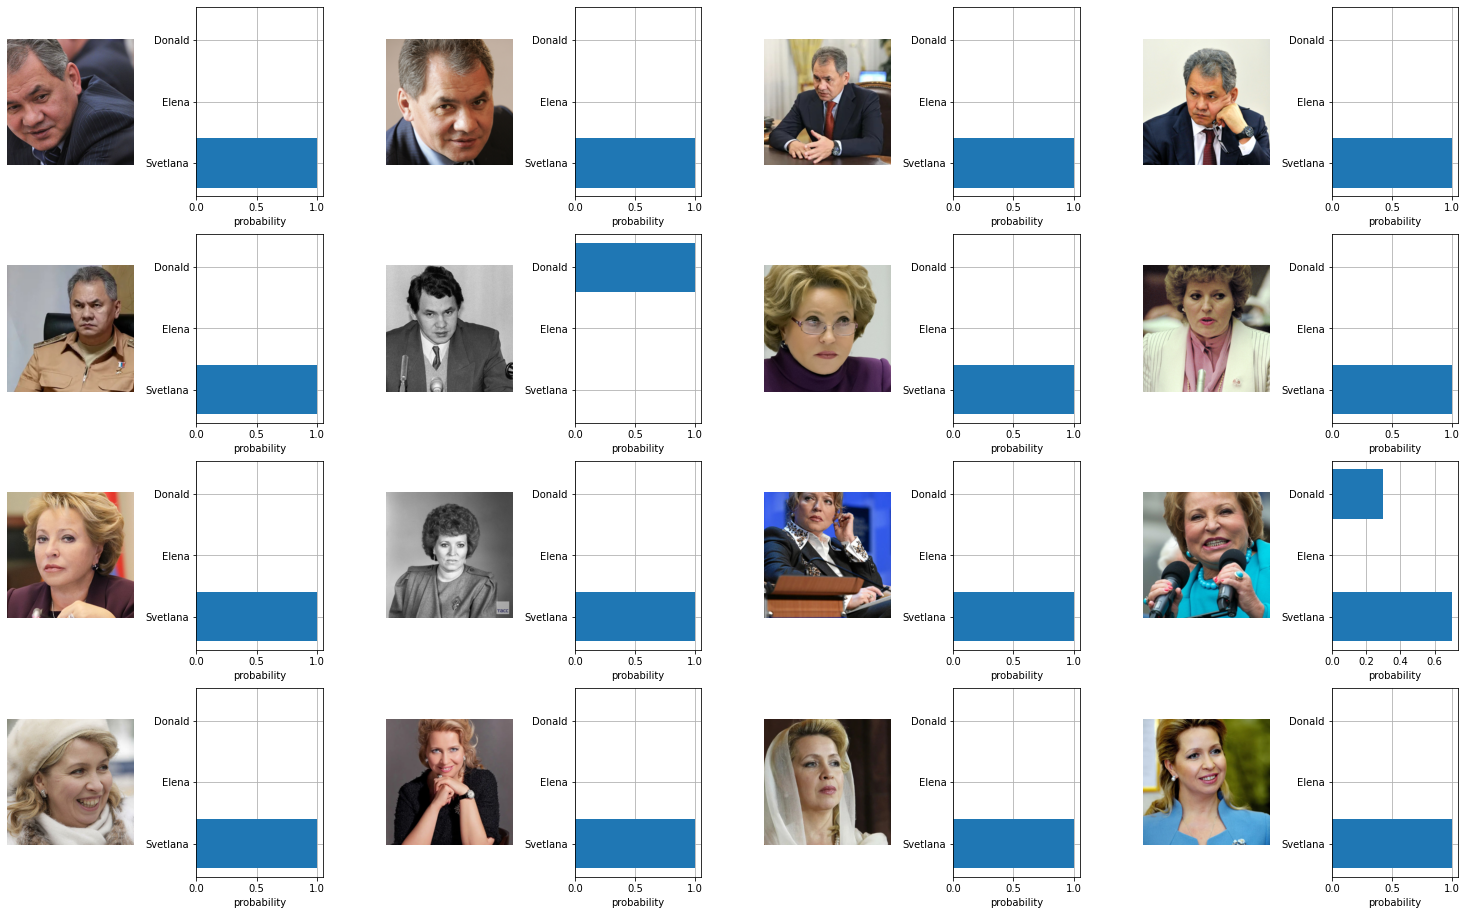

In [19]:
show_results(image_features, text_features, class_names)

You can see that CLIP is not doing great with these labels.

Let's play with the labels a bit and see if it changes anything.

# Experiments

Below we will try to change lables to see how it affects the results.

## Change names to more common in the US

Let's change names to a more common names in the US. CLIP was supposedly trained on English language corpus and didn't encounter much of Russian names (this is a guess).

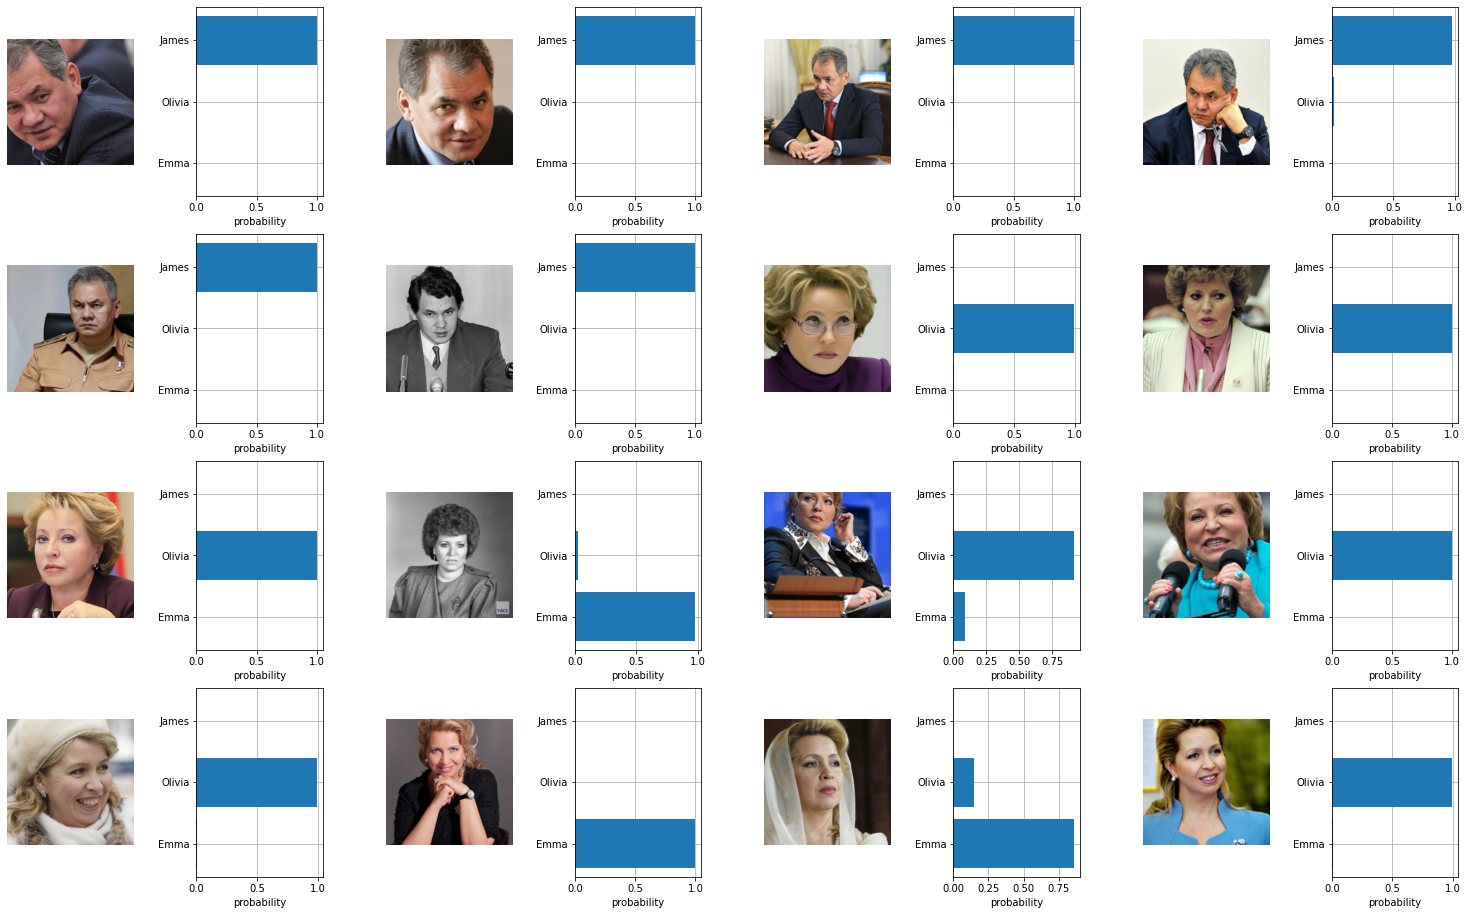

In [20]:
class_names = ['James', 'Olivia', 'Emma']
class_captions = [f"An image depicting a {x}" for x in class_names]
text_input = clip.tokenize(class_captions).to(device)

with torch.no_grad():
    text_features = model.encode_text(text_input).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

show_results(image_features, text_features, class_names)

Much, much better!

Looks like we can classify male/female easily. Let's have a look.

## Male/female classification


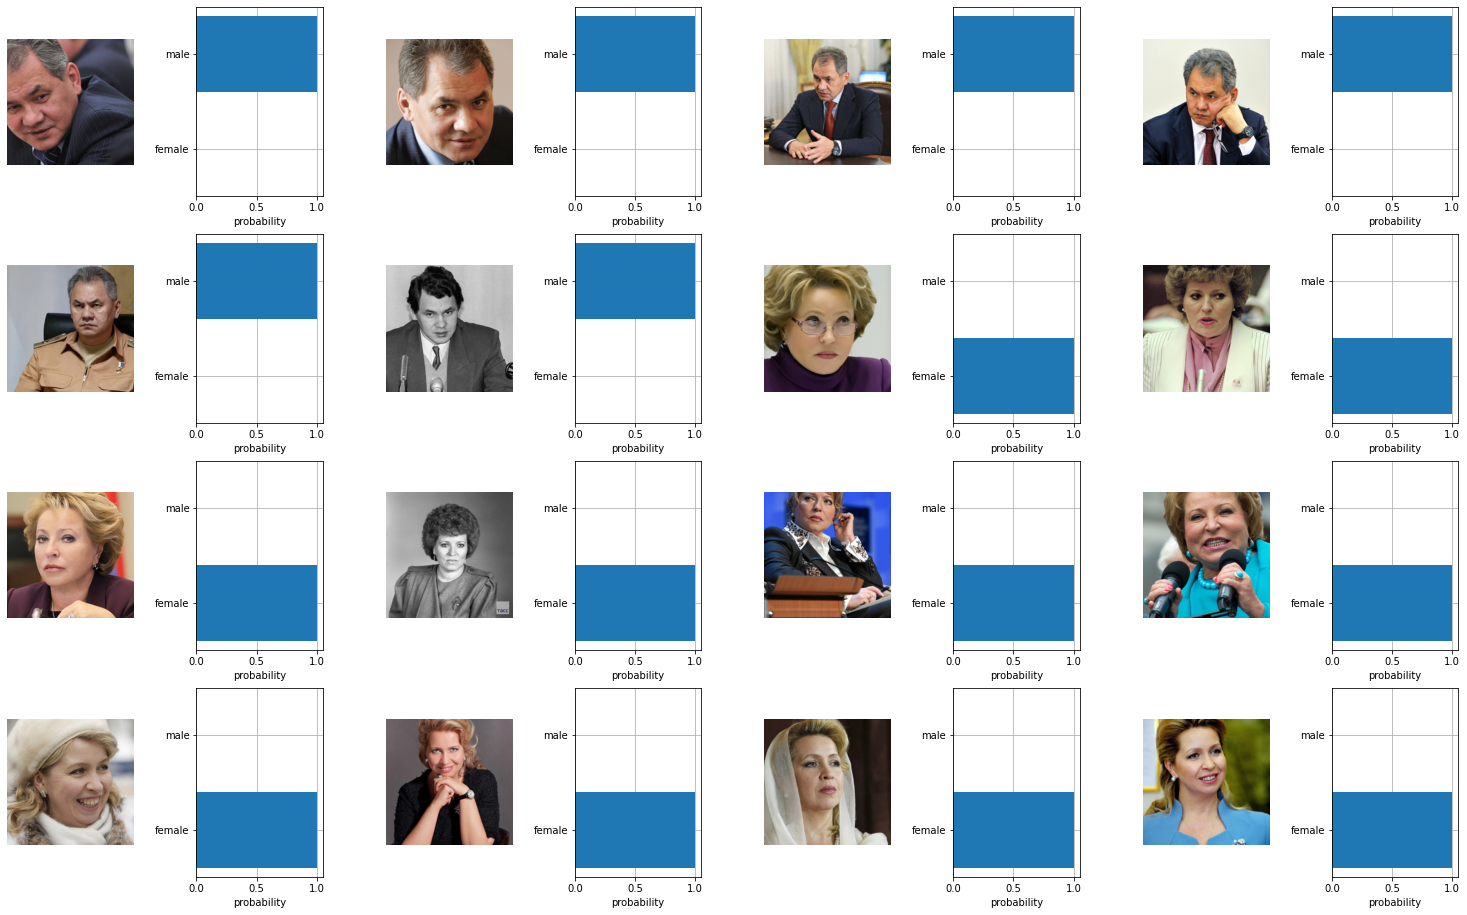

In [21]:
class_names = ['male', 'female']
class_captions = [f"An image depicting a {x}" for x in class_names]
text_input = clip.tokenize(class_captions).to(device)

with torch.no_grad():
    text_features = model.encode_text(text_input).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

show_results(image_features, text_features, class_names)

That was pretty accurate. Next step in this direction will be to test it on other ethnicities.

## Object detection/presence?

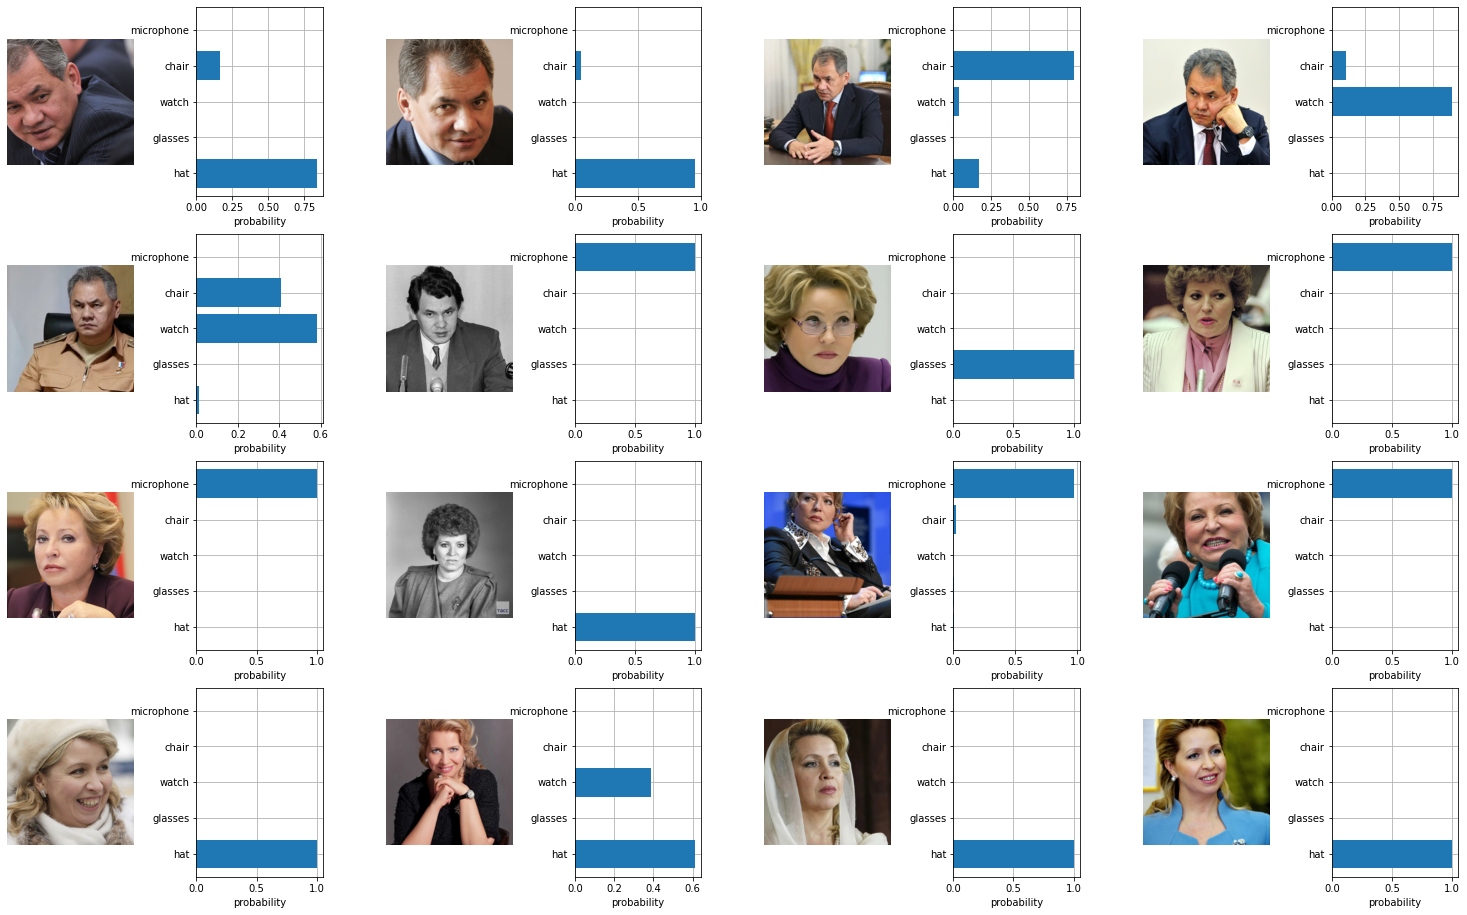

In [25]:
# class_names = ['microphone', 'chair', 'watch', 'glasses']
class_names = ['microphone', 'chair', 'watch', 'glasses', 'hat']
class_captions = [f"An image showing a {x}" for x in class_names]
text_input = clip.tokenize(class_captions).to(device)

with torch.no_grad():
    text_features = model.encode_text(text_input).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

show_results(image_features, text_features, class_names)

## Objects counting by words and digits

Since we have at least one image with two microphones, I wanted to see if CLIP can detect it. We test both variants: `two` and `2`.

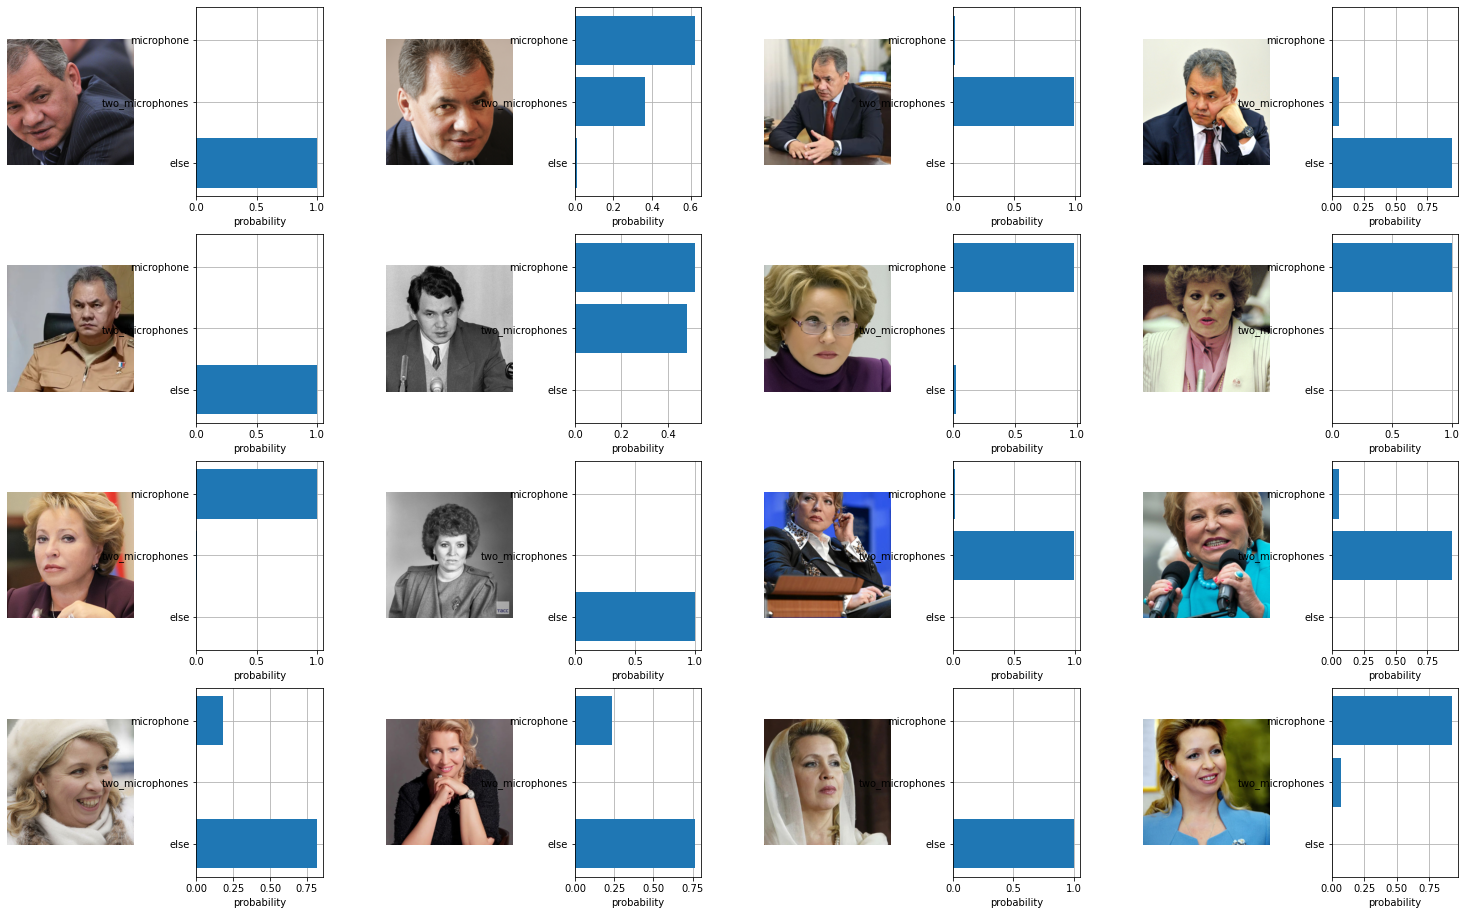

In [26]:
class_names = ['microphone', 'two_microphones', "else"]
class_captions = ["An image showing a microphone", "An image showing two microphones", "An image showing something else"]
text_input = clip.tokenize(class_captions).to(device)

with torch.no_grad():
    text_features = model.encode_text(text_input).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

show_results(image_features, text_features, class_names)

We can also see that words description is better than digits-based. Compare above image in row 3 column 4 to the one below:

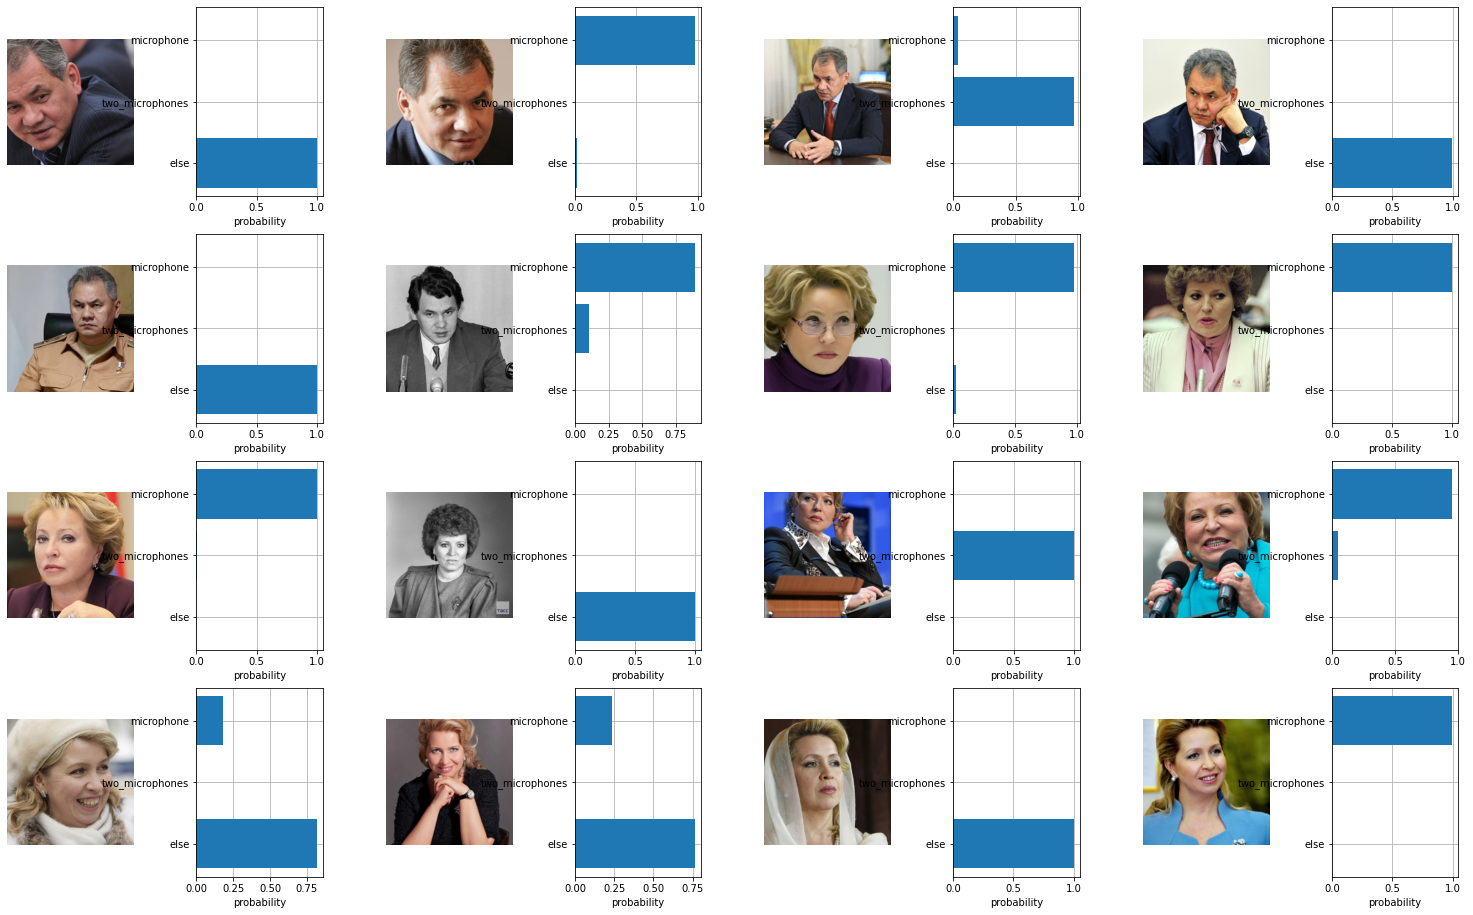

In [27]:
class_names = ['microphone', 'two_microphones', "else"]
class_captions = ["An image showing a microphone", "An image showing 2 microphones", "An image showing something else"]
text_input = clip.tokenize(class_captions).to(device)

with torch.no_grad():
    text_features = model.encode_text(text_input).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

show_results(image_features, text_features, class_names)

## Find suitable name for good feature separation

Playing with the names a bit, I found a combination, which allows to distinguish between two females. Combinations that I've tried:

* Sophia, Emma
* Anna, Emma



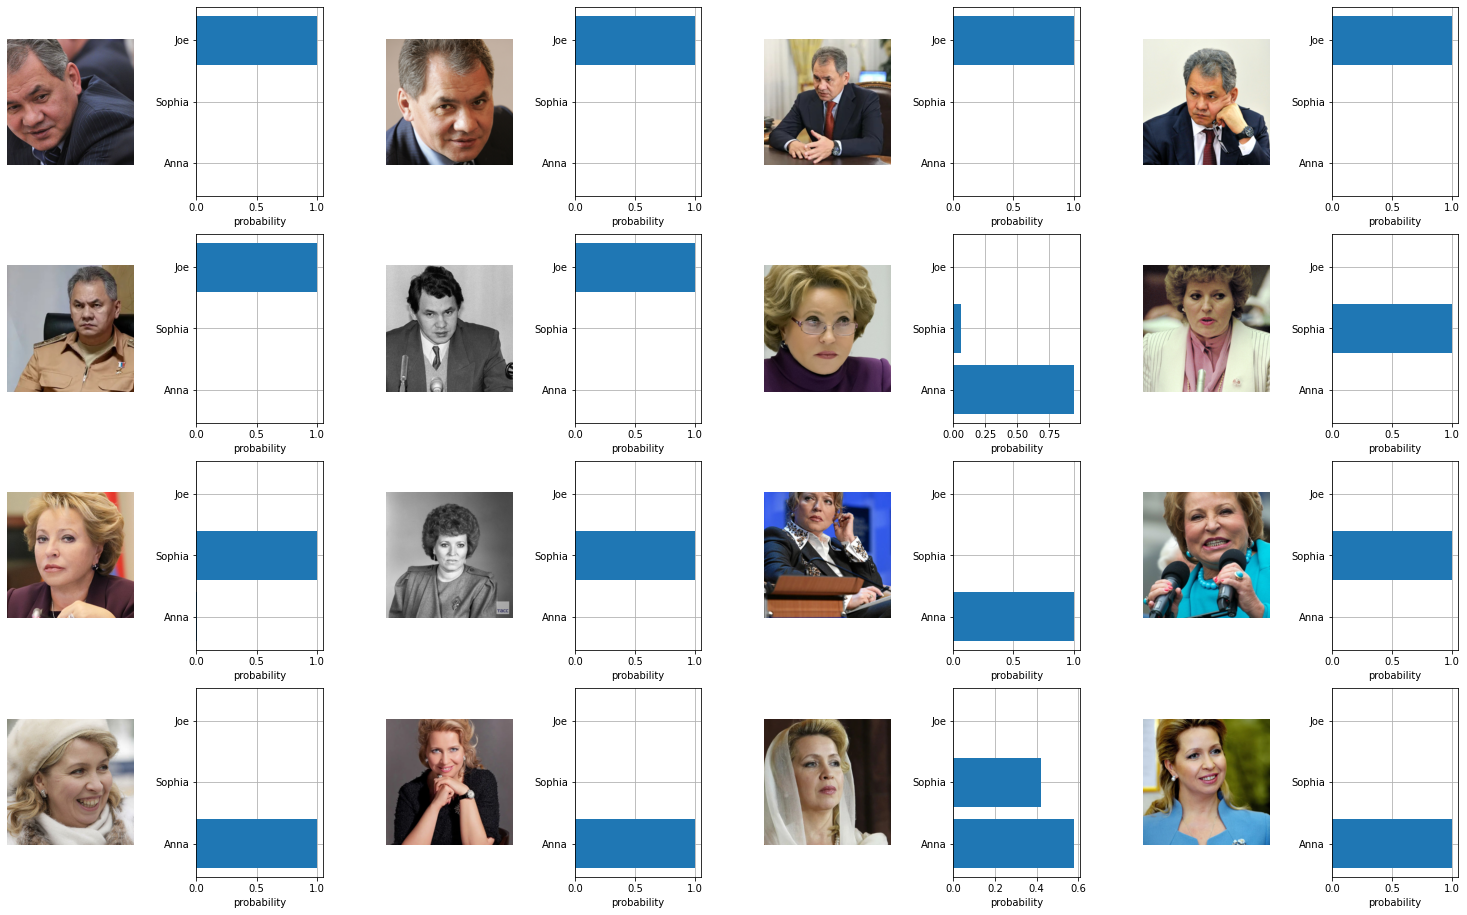

In [ ]:
class_names = ['Joe', 'Sophia', 'Anna']
class_captions = [f"A photo of {x}" for x in class_names]
text_input = clip.tokenize(class_captions).to(device)

with torch.no_grad():
    text_features = model.encode_text(text_input).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

show_results(image_features, text_features, class_names)

## Add conditions to class descriptions

The idea here is that we add a condition in text description. For this small dataset this is very fragile. The combination bellow works OK, but try to change `Sophia` to something else and the results won't be so good. 

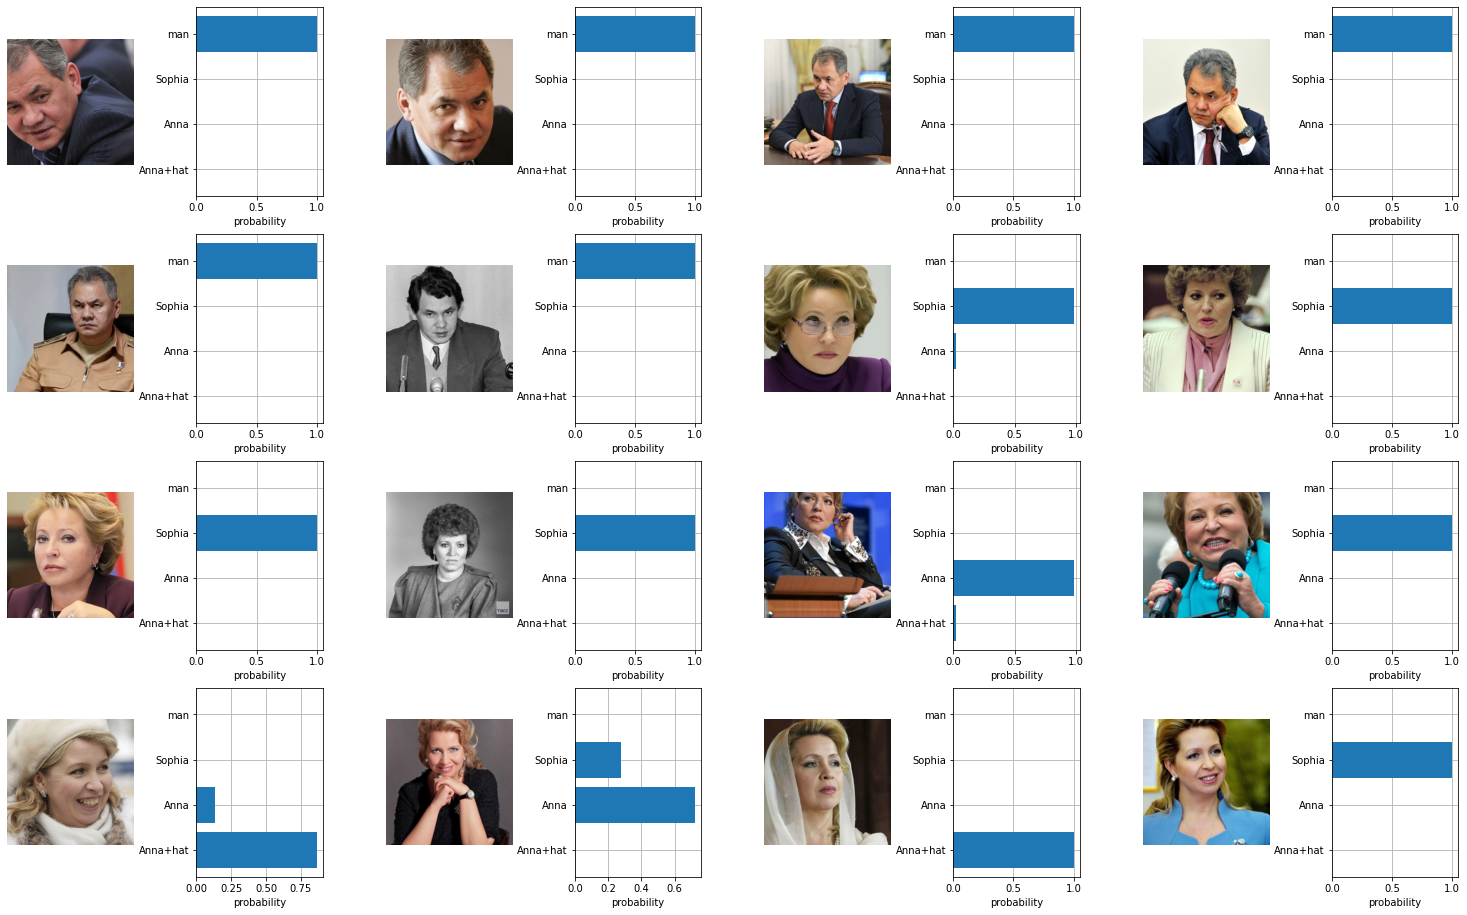

In [ ]:
class_names = ["man", "Sophia", "Anna", "Anna+hat"]
class_captions = ["A photo of a man", "A photo of Sophia", "A photo of a Anna", "A photo of a Anna with head covered"]
text_input = clip.tokenize(class_captions).to(device)

with torch.no_grad():
    text_features = model.encode_text(text_input).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

show_results(image_features, text_features, class_names)